In [1]:
!pip3 install pybullet --upgrade --user

     |████████████████████████████████| 79.0 MB 2.1 MB/s eta 0:00:01     |█████████▋                      | 23.8 MB 1.3 MB/s eta 0:00:42
  Created wheel for pybullet: filename=pybullet-3.1.7-cp37-cp37m-macosx_10_9_x86_64.whl size=67488518 sha256=59cb04eac1dd868a40a4a21ff00c5c11eb7e958e8016e5ed1692d505ce8a626f
  Stored in directory: /Users/user/Library/Caches/pip/wheels/70/1c/62/86c8b68885c24123d87c5392d6678aa2b68a1796c8113e1aa6
Successfully built pybullet
  Attempting uninstall: pybullet
    Found existing installation: pybullet 3.0.8
    Uninstalling pybullet-3.0.8:
      Successfully uninstalled pybullet-3.0.8
You should consider upgrading via the '/Users/user/anaconda3/envs/pwil/bin/python -m pip install --upgrade pip' command.


In [1]:
import torch
import gym
import argparse
import os
import pickle
import numpy as np
import random
import torch.optim as optim
import torch_optimizer as th_optim
import pybullet_envs

from torch.utils.data import DataLoader, ConcatDataset
from torch.distributions import Normal
from models import *
from utils import *
from dataset import *

In [2]:
import matplotlib.pyplot as plt
import numpy as np

def plot_simple_bco(records, records_f, s=100, off=0.8):
    ypoints = np.array(records)
    plt.plot(ypoints, linestyle = 'dotted')
    ypoints[1:] = ypoints[1:] #- (np.random.rand(ypoints[1:].shape[0])-0.25)*2*s + (np.random.rand(ypoints[1:].shape[0])-off)*4*s
    plt.plot(ypoints, linestyle = 'dotted')
    plt.show()

In [3]:
def inv_model_training(transitions, inv_model, ep_num=100):
    inv_dataset = transition_dataset(transitions)
    inv_dataset_list.append(inv_dataset)
    inv_dataset_final = ConcatDataset(inv_dataset_list)
    inv_loader = DataLoader(inv_dataset_final, batch_size=1024, shuffle=True, num_workers=4)

    inv_opt = optim.Adam(inv_model.parameters(), lr=1e-3, weight_decay=0.0001)
    """
    inv_opt_yogi = th_optim.Yogi(
        inv_model.parameters(),
        lr= 1e-2,
        betas=(0.9, 0.999),
        eps=1e-3,
        initial_accumulator=1e-6,
        weight_decay=0,
    )

    inv_opt = th_optim.Lookahead(inv_opt_yogi,  alpha=0.5)#k=5
    """
    inv_loss = nn.MSELoss()
    #inv_loss = nn.L1Loss()

    for epoch in range(ep_num): 
        running_loss = 0
        for i, data in enumerate(inv_loader):
            s, a, s_prime = data
            inv_opt.zero_grad()
            """
            a_pred = inv_model(s.float(), s_prime.float())
            """
            sprime_m, sprime_v = inv_model(s.float(), a.float()) 
            pred = Normal(sprime_m, sprime_v).rsample()
            loss = inv_loss(pred, s_prime.float())
            #loss = inv_loss(a_pred, a.float())
            loss.backward()
            running_loss += loss.item()
            if i%100 == 99:
                running_loss = 0
            inv_opt.step()
        if epoch%20==0:
            print('Epoch:%d Batch:%d Loss:%.5f'%(epoch, i+1, loss))
    print('Done!')
    return inv_model

def train_bc(trajs, policy, dynamics,  ep_num=50, sample_itr=500):
    bc_dataset = imitation_dataset(trajs)
    bc_loader = DataLoader(bc_dataset, batch_size=1024, shuffle=True, num_workers=4)
    print('Learning policy....')
    #bc_opt = optim.Adam(policy.parameters(), lr=1e-3, weight_decay=0.0001)
    #"""
    bc_opt_yogi = th_optim.Yogi(
        policy.parameters(),
        lr= 1e-2,
        betas=(0.9, 0.999),
        eps=1e-3,
        initial_accumulator=1e-6,
        weight_decay=0,
    )

    bc_opt = th_optim.Lookahead(bc_opt_yogi,  alpha=0.5)#k=5,
    #"""
    bc_loss = nn.MSELoss()
    # bc_loss = nn.L1Loss()

    for epoch in range(ep_num):  
        running_loss = 0
        for i, data in enumerate(bc_loader):
            s, s_prime = data
            bc_opt.zero_grad()
            
            
            #"""
            a_mu, a_sigma = policy(s.float())
            a_pred = Normal(loc=a_mu, scale=a_sigma).rsample()
            #"""
            s_m, s_v = dynamics(s, a_pred) 
            
            
            preds = Normal(s_m, s_v).rsample([sample_itr])
            new_gts = torch.cat(sample_itr*[s_prime]).view(sample_itr,s_prime.shape[0],s_prime.shape[1])
            loss = bc_loss(preds, new_gts)
            #print(loss, loss.shape, preds.shape, new_gts.shape)
            
            #for sid in range(sample_itr):
                #"""
                #a_mu, a_sigma = policy(s.float())
                #a_pred = Normal(loc=a_mu, scale=a_sigma).rsample()
                #"""
                #s_m, s_v = dynamics(s, a_pred) 
                #print(pred.shape, s.shape, s_prime.shape)
                #print(pred[0])
                #loss = loss + bc_loss(preds[sid], s_prime)
                
            running_loss += loss.item()
            loss.backward()
            if i%20 == 19:
                running_loss = 0
            bc_opt.step()
        if epoch%10==0:
            print('Epoch:%d Batch:%d Loss:%.3f'%(epoch, i+1, loss))

    print('Done!')
    return policy

In [4]:
env_list = ["Pendulum-v0", "BipedalWalker-v3", "Walker2DBulletEnv-v0", "HopperBulletEnv-v0", "HalfCheetahBulletEnv-v0", "AntBulletEnv-v0", "HumanoidBulletEnv-v0"]
ENV_NAME = env_list[-3]
env=ENV_NAME
runs = 20
inv_samples = 1000
max_steps = 500
expert_path='experts/'
DEMO_DIR = os.path.join(expert_path, env+'.pkl')
M = inv_samples

In [5]:

try:
    demos = np.load("experts/states_expert_walker_.npy")[:10]
except:
    with open(DEMO_DIR, 'rb') as f:
        trajs = pickle.load(f)

        
env = gym.make(ENV_NAME)


/Users/user/anaconda3/envs/pwil/lib/python3.7/site-packages/gym/logger.py:30: UserWarning: WARN: Box bound precision lowered by casting to float32
  warnings.warn(colorize('%s: %s'%('WARN', msg % args), 'yellow'))


In [6]:
demos = []
for t_id, traj in enumerate(trajs):
    demo =[]
    #print(t_id)
    for item in traj:    
        obs = item['observation']
        #obs = list(obs)
        #print(obs)
        demo.append(obs)
    #print(np.array(demo).shape)
    demos.append(np.array(demo))

print(np.array(demos).shape)
demos = demos[:10]

(50, 1000, 26)


In [7]:

    
policy = policy_continuous(env.observation_space.shape[0],64,env.action_space.shape[0], uncertain=True)#.cuda()
inv_model = forward_dynamics_continuous(env.observation_space.shape[0],100,env.action_space.shape[0], uncertain=True)#.cuda()

#get_action_labels(inv_model, demos, 'continuous')

In [8]:
test_rewards_envs = []

for en in env_list[1:]:
    print("############# start "+en+" training ###################")

    ENV_NAME = en#env_list[3]
    env=ENV_NAME
    runs = 20
    inv_samples = 1000
    max_steps = 500
    expert_path='experts/'
    DEMO_DIR = os.path.join(expert_path, env+'.pkl')
    M = inv_samples

    try:
        demos = np.load("experts/states_expert_walker_.npy")[:10]
    except:
        with open(DEMO_DIR, 'rb') as f:
            trajs = pickle.load(f)


    env = gym.make(ENV_NAME)
    demos = []
    for t_id, traj in enumerate(trajs):
        demo =[]
        #print(t_id)
        for item in traj:    
            obs = item['observation']
            #obs = list(obs)
            #print(obs)
            demo.append(obs)
        #print(np.array(demo).shape)
        demos.append(np.array(demo))

    print(np.array(demos).shape)
    demos = demos[:10]



    policy = policy_continuous(env.observation_space.shape[0],64,env.action_space.shape[0], uncertain=True)#.cuda()
    inv_model = forward_dynamics_continuous(env.observation_space.shape[0],100,env.action_space.shape[0], uncertain=True)#.cuda()
    inv_model_best = None
    reward_best = -1000

    inv_dataset_list = []
    use_policy = False

    transitions = []
    test_rewards = []
    for steps in range(runs):
        print('######## STEP %d #######'%(steps+1))
        ### GET SAMPLES FOR LEARNING INVERSE MODEL
        print('Collecting transitions for learning inverse model....')
        if steps > 0:
            use_policy = True


        trans_samples, avg_reward = gen_inv_samples(env, policy.cpu(), M, 'continuous', use_policy, max_steps=max_steps)
        transitions = transitions+trans_samples
        """
        if len(transitions) > 92000:
            transitions = random.sample(transitions,92000)
        """
        test_rewards.append(avg_reward)
        print('Done!', np.array(transitions).shape)

        ### LEARN THE INVERSE MODEL
        """
        if avg_reward > reward_best and steps!=0:
            inv_model_best = inv_model
            reward_best = avg_reward
        elif steps==0:
            reward_best = avg_reward
            inv_model_best = forward_dynamics_continuous(env.observation_space.shape[0],100,env.action_space.shape[0], uncertain=True)#.cuda()
        else:
            inv_model = inv_model_best#forward_dynamics_continuous(env.observation_space.shape[0],100,env.action_space.shape[0], uncertain=True)#.cuda()
        """
        #inv_model = forward_dynamics_continuous(env.observation_space.shape[0],100,env.action_space.shape[0], uncertain=True)#.cuda()
        
        print('Learning inverse model....')
        inv_model = inv_model_training(transitions, inv_model)

        ### GET ACTIONS FOR DEMOS
        inv_model.cpu()
        print('Getting labels for demos....')
        trajs = get_state_labels(demos)
        print('Done!')


        ### PERFORM BEHAVIORAL CLONING
        policy = train_bc(trajs, policy, inv_model, sample_itr=400)

    torch.save(policy, ENV_NAME+'.pt')
    test_rewards_envs.append(test_rewards)

############# start BipedalWalker-v3 training ###################


/Users/user/anaconda3/envs/pwil/lib/python3.7/site-packages/ipykernel_launcher.py:35: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.


(49,)
######## STEP 1 #######
reward: -113.42819713090422 setps: 45 count: 45
reward: -104.53504114604245 setps: 76 count: 121
reward: -98.1807835285524 setps: 58 count: 179
reward: -24.84264123198795 setps: 500 count: 679
avg rewards: -85.24666575937175
Done! (1000, 3)
Learning inverse model....


/Users/user/anaconda3/envs/pwil/lib/python3.7/site-packages/ipykernel_launcher.py:65: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.


Epoch:0 Batch:1 Loss:1.30817
Epoch:20 Batch:1 Loss:0.46234
Epoch:40 Batch:1 Loss:0.14068
Epoch:60 Batch:1 Loss:0.09420
Epoch:80 Batch:1 Loss:0.07061
Done!
Getting labels for demos....
Done!
Learning policy....
Epoch:0 Batch:9 Loss:0.195
Epoch:10 Batch:9 Loss:0.115
Epoch:20 Batch:9 Loss:0.109
Epoch:30 Batch:9 Loss:0.106
Epoch:40 Batch:9 Loss:0.101
Done!
######## STEP 2 #######
reward: -117.11789462951322 setps: 46 count: 46
reward: -116.3433254983658 setps: 45 count: 91
reward: -116.3801485413167 setps: 45 count: 136
reward: -117.44115629367158 setps: 48 count: 184
reward: -116.66818331891841 setps: 47 count: 231
reward: -116.87212064207779 setps: 47 count: 278
reward: -116.38647374093843 setps: 44 count: 322
reward: -117.10073666971425 setps: 46 count: 368
reward: -116.07901677489406 setps: 42 count: 410
reward: -116.26770894675516 setps: 52 count: 462
reward: -116.82460280121863 setps: 45 count: 507
reward: -116.87125103012349 setps: 46 count: 553
reward: -116.51032820627373 setps: 44

avg rewards: 14.160764850951267
Done! (12000, 3)
Learning inverse model....
Epoch:0 Batch:77 Loss:0.01719
Epoch:20 Batch:77 Loss:0.01659
Epoch:40 Batch:77 Loss:0.01562
Epoch:60 Batch:77 Loss:0.02161
Epoch:80 Batch:77 Loss:0.01844
Done!
Getting labels for demos....
Done!
Learning policy....
Epoch:0 Batch:9 Loss:0.026
Epoch:10 Batch:9 Loss:0.024
Epoch:20 Batch:9 Loss:0.031
Epoch:30 Batch:9 Loss:0.026
Epoch:40 Batch:9 Loss:0.026
Done!
######## STEP 13 #######
reward: 88.02722132326564 setps: 500 count: 500
reward: -30.939239945817747 setps: 406 count: 906
avg rewards: 28.543990688723945
Done! (13000, 3)
Learning inverse model....
Epoch:0 Batch:89 Loss:0.01689
Epoch:20 Batch:89 Loss:0.01688
Epoch:40 Batch:89 Loss:0.01714
Epoch:60 Batch:89 Loss:0.01641
Epoch:80 Batch:89 Loss:0.01717
Done!
Getting labels for demos....
Done!
Learning policy....
Epoch:0 Batch:9 Loss:0.026
Epoch:10 Batch:9 Loss:0.029
Epoch:20 Batch:9 Loss:0.023
Epoch:30 Batch:9 Loss:0.023
Epoch:40 Batch:9 Loss:0.028
Done!
#####

reward: 15.155802202856284 setps: 11 count: 929
reward: 16.002085692604304 setps: 12 count: 941
reward: 20.760759302791847 setps: 16 count: 957
reward: 15.988287944735204 setps: 14 count: 971
reward: 22.236783421068687 setps: 24 count: 995
avg rewards: 16.660785166834955
Done! (1000, 3)
Learning inverse model....
Epoch:0 Batch:1 Loss:1.31638
Epoch:20 Batch:1 Loss:0.34947
Epoch:40 Batch:1 Loss:0.12588
Epoch:60 Batch:1 Loss:0.08091
Epoch:80 Batch:1 Loss:0.05153
Done!
Getting labels for demos....
Done!
Learning policy....
Epoch:0 Batch:10 Loss:0.143
Epoch:10 Batch:10 Loss:0.095
Epoch:20 Batch:10 Loss:0.094
Epoch:30 Batch:10 Loss:0.094
Epoch:40 Batch:10 Loss:0.092
Done!
######## STEP 2 #######
reward: -2.663067228817092 setps: 48 count: 48
reward: -1.9333013157302066 setps: 52 count: 100
reward: -0.23313707945344442 setps: 52 count: 152
reward: -3.41092196496029 setps: 54 count: 206
reward: -4.044247181971151 setps: 50 count: 256
reward: -1.4629395313546423 setps: 55 count: 311
reward: -0.

reward: 21.65518491613911 setps: 20 count: 819
reward: 26.27284825462411 setps: 23 count: 842
reward: 26.048897867061893 setps: 25 count: 867
reward: 27.924573522782882 setps: 27 count: 894
reward: 65.39305627564318 setps: 57 count: 951
reward: 25.467102354652884 setps: 23 count: 974
reward: 25.707428262829488 setps: 24 count: 998
avg rewards: 26.03826305267888
Done! (6000, 3)
Learning inverse model....
Epoch:0 Batch:21 Loss:0.00707
Epoch:20 Batch:21 Loss:0.00667
Epoch:40 Batch:21 Loss:0.00769
Epoch:60 Batch:21 Loss:0.00588
Epoch:80 Batch:21 Loss:0.00676
Done!
Getting labels for demos....
Done!
Learning policy....
Epoch:0 Batch:10 Loss:0.023
Epoch:10 Batch:10 Loss:0.023
Epoch:20 Batch:10 Loss:0.024
Epoch:30 Batch:10 Loss:0.022
Epoch:40 Batch:10 Loss:0.022
Done!
######## STEP 7 #######
reward: 24.749040722541395 setps: 20 count: 20
reward: 20.488565265157376 setps: 17 count: 37
reward: 23.25693154416658 setps: 17 count: 54
reward: 25.625293775311725 setps: 20 count: 74
reward: 22.955914

reward: 19.808223314842326 setps: 16 count: 349
reward: 17.100784523626494 setps: 15 count: 364
reward: 17.693099053263722 setps: 14 count: 378
reward: 18.217189651641817 setps: 15 count: 393
reward: 21.313251835343543 setps: 16 count: 409
reward: 17.356840264089985 setps: 15 count: 424
reward: 17.696436602786704 setps: 15 count: 439
reward: 19.868315993607396 setps: 15 count: 454
reward: 17.42197048474482 setps: 14 count: 468
reward: 18.03371705368336 setps: 15 count: 483
reward: 19.342984384267766 setps: 16 count: 499
reward: 18.020959198809578 setps: 16 count: 515
reward: 19.949526017133028 setps: 16 count: 531
reward: 18.564396151255643 setps: 15 count: 546
reward: 21.08046096954931 setps: 17 count: 563
reward: 19.898993568510924 setps: 16 count: 579
reward: 19.943163689956414 setps: 16 count: 595
reward: 17.68083970175503 setps: 16 count: 611
reward: 20.736340194374502 setps: 16 count: 627
reward: 19.28783486410248 setps: 15 count: 642
reward: 18.618184192296756 setps: 15 count: 6

reward: 24.398096735247236 setps: 19 count: 927
reward: 22.774188057539863 setps: 21 count: 948
reward: 22.89063857197616 setps: 22 count: 970
reward: 20.759537951803942 setps: 19 count: 989
avg rewards: 19.722817774705657
Done! (11000, 3)
Learning inverse model....
Epoch:0 Batch:65 Loss:0.00605
Epoch:20 Batch:65 Loss:0.00585
Epoch:40 Batch:65 Loss:0.00567
Epoch:60 Batch:65 Loss:0.00615
Epoch:80 Batch:65 Loss:0.00638
Done!
Getting labels for demos....
Done!
Learning policy....
Epoch:0 Batch:10 Loss:0.025
Epoch:10 Batch:10 Loss:0.024
Epoch:20 Batch:10 Loss:0.023
Epoch:30 Batch:10 Loss:0.023
Epoch:40 Batch:10 Loss:0.022
Done!
######## STEP 12 #######
reward: 18.02129056980484 setps: 17 count: 17
reward: 19.456233431732105 setps: 16 count: 33
reward: 18.47658223959588 setps: 16 count: 49
reward: 14.912943219827138 setps: 13 count: 62
reward: 15.477779671957247 setps: 15 count: 77
reward: 16.284979590223518 setps: 15 count: 92
reward: 18.80845346510905 setps: 17 count: 109
reward: 20.25600

reward: 15.042478368301817 setps: 13 count: 171
reward: 15.903180290925956 setps: 13 count: 184
reward: 15.624505736387801 setps: 13 count: 197
reward: 20.956951596892033 setps: 19 count: 216
reward: 15.285034951660782 setps: 13 count: 229
reward: 15.78649196508777 setps: 13 count: 242
reward: 14.93491884811374 setps: 13 count: 255
reward: 16.095810915467155 setps: 14 count: 269
reward: 16.504107332309648 setps: 14 count: 283
reward: 15.86389586543228 setps: 13 count: 296
reward: 15.529938811819012 setps: 13 count: 309
reward: 15.574746185430559 setps: 13 count: 322
reward: 14.877717063181624 setps: 13 count: 335
reward: 15.310574284421453 setps: 13 count: 348
reward: 15.415054147894262 setps: 13 count: 361
reward: 15.196331311101677 setps: 13 count: 374
reward: 16.292751757027872 setps: 13 count: 387
reward: 19.21306336843845 setps: 18 count: 405
reward: 18.60605527685693 setps: 18 count: 423
reward: 14.673294545378303 setps: 14 count: 437
reward: 14.938590901682618 setps: 13 count: 4

reward: 15.518215483284438 setps: 13 count: 547
reward: 16.507406383140186 setps: 13 count: 560
reward: 15.350489521543203 setps: 13 count: 573
reward: 22.938343645157868 setps: 22 count: 595
reward: 14.963276932628652 setps: 13 count: 608
reward: 15.90627476297668 setps: 14 count: 622
reward: 19.920101991860427 setps: 18 count: 640
reward: 15.690878219796284 setps: 13 count: 653
reward: 15.471903058244788 setps: 13 count: 666
reward: 17.03169812325504 setps: 14 count: 680
reward: 19.95243324366311 setps: 17 count: 697
reward: 20.810365766265026 setps: 23 count: 720
reward: 15.648611065043948 setps: 13 count: 733
reward: 15.95061546104116 setps: 13 count: 746
reward: 91.60644978030902 setps: 74 count: 820
reward: 15.56419663819106 setps: 13 count: 833
reward: 30.764657990158593 setps: 27 count: 860
reward: 16.36436303438677 setps: 13 count: 873
reward: 16.340418702295572 setps: 13 count: 886
reward: 15.65428188769729 setps: 13 count: 899
reward: 16.70764603285206 setps: 13 count: 912
r

reward: 9.055634294358605 setps: 13 count: 323
reward: 11.94769568148622 setps: 14 count: 337
reward: 11.572164544684345 setps: 14 count: 351
reward: 12.418644782771297 setps: 13 count: 364
reward: 13.419393564239726 setps: 18 count: 382
reward: 9.298861008357196 setps: 14 count: 396
reward: 11.133772182269604 setps: 14 count: 410
reward: 11.121150765402126 setps: 14 count: 424
reward: 9.928228433833283 setps: 12 count: 436
reward: 11.870716723329679 setps: 15 count: 451
reward: 9.218782582471611 setps: 13 count: 464
reward: 10.483623294188872 setps: 14 count: 478
reward: 11.145877665470472 setps: 15 count: 493
reward: 10.234809022217814 setps: 13 count: 506
reward: 10.485368624168041 setps: 14 count: 520
reward: 12.77971575509291 setps: 15 count: 535
reward: 9.955175618837528 setps: 13 count: 548
reward: 9.831871506781315 setps: 13 count: 561
reward: 10.928143341759277 setps: 14 count: 575
reward: 9.934227533738884 setps: 13 count: 588
reward: 11.19785970913217 setps: 14 count: 602
re

reward: -0.07605058113258645 setps: 28 count: 747
reward: 0.11864012233418064 setps: 29 count: 776
reward: 6.286791210537465 setps: 31 count: 807
reward: 2.781293455743434 setps: 28 count: 835
reward: 0.7297758101381744 setps: 27 count: 862
reward: -1.5148074898184867 setps: 30 count: 892
reward: -0.42050623090035666 setps: 28 count: 920
reward: 5.023043079748459 setps: 30 count: 950
reward: -0.566911241988965 setps: 28 count: 978
avg rewards: 0.6177594795147113
Done! (2000, 3)
Learning inverse model....
Epoch:0 Batch:3 Loss:0.06059
Epoch:20 Batch:3 Loss:0.03058
Epoch:40 Batch:3 Loss:0.02432
Epoch:60 Batch:3 Loss:0.02167
Epoch:80 Batch:3 Loss:0.01967
Done!
Getting labels for demos....
Done!
Learning policy....
Epoch:0 Batch:10 Loss:0.053
Epoch:10 Batch:10 Loss:0.050
Epoch:20 Batch:10 Loss:0.047
Epoch:30 Batch:10 Loss:0.047
Epoch:40 Batch:10 Loss:0.047
Done!
######## STEP 3 #######
reward: 0.1067599212983612 setps: 31 count: 31
reward: -0.3680540101864618 setps: 30 count: 61
reward: -1.

reward: 17.79572062387597 setps: 48 count: 243
reward: 13.218316495051841 setps: 38 count: 281
reward: 23.018253959491272 setps: 40 count: 321
reward: 15.43970755293267 setps: 41 count: 362
reward: 18.555296078673567 setps: 42 count: 404
reward: 21.15155374106253 setps: 36 count: 440
reward: 24.597380655101738 setps: 37 count: 477
reward: 17.78367453453102 setps: 38 count: 515
reward: 29.403883280872833 setps: 46 count: 561
reward: 13.851184794155415 setps: 40 count: 601
reward: 12.965699238092931 setps: 41 count: 642
reward: 21.947505334636663 setps: 39 count: 681
reward: 14.029492060987103 setps: 38 count: 719
reward: 15.816355136445775 setps: 46 count: 765
reward: 11.82292988838162 setps: 42 count: 807
reward: 15.889073905872644 setps: 39 count: 846
reward: 14.242117936593418 setps: 38 count: 884
reward: 27.639891667872153 setps: 44 count: 928
reward: 22.290482625481673 setps: 45 count: 973
avg rewards: 19.13041368888486
Done! (7000, 3)
Learning inverse model....
Epoch:0 Batch:28 Lo

reward: 46.695278467016756 setps: 35 count: 716
reward: 37.47572535844956 setps: 29 count: 745
reward: 36.47332091474818 setps: 26 count: 771
reward: 40.6958458245761 setps: 34 count: 805
reward: 54.10819359393499 setps: 45 count: 850
reward: 40.276163243465994 setps: 30 count: 880
reward: 41.204281997126245 setps: 31 count: 911
reward: 38.09490365313249 setps: 28 count: 939
reward: 34.526415698655185 setps: 23 count: 962
avg rewards: 41.54489756479423
Done! (13000, 3)
Learning inverse model....
Epoch:0 Batch:89 Loss:0.00589
Epoch:20 Batch:89 Loss:0.00532
Epoch:40 Batch:89 Loss:0.00485
Epoch:60 Batch:89 Loss:0.00452
Epoch:80 Batch:89 Loss:0.00550
Done!
Getting labels for demos....
Done!
Learning policy....
Epoch:0 Batch:10 Loss:0.019
Epoch:10 Batch:10 Loss:0.020
Epoch:20 Batch:10 Loss:0.021
Epoch:30 Batch:10 Loss:0.018
Epoch:40 Batch:10 Loss:0.021
Done!
######## STEP 14 #######
reward: 53.2736336627713 setps: 40 count: 40
reward: 40.79701607475582 setps: 30 count: 70
reward: 55.7048272

reward: 65.77640295711026 setps: 45 count: 809
reward: 51.834654275362865 setps: 35 count: 844
reward: 51.04473414283566 setps: 37 count: 881
reward: 61.067438832776695 setps: 41 count: 922
reward: 55.866446560411724 setps: 37 count: 959
avg rewards: 53.464786077203854
Done! (17000, 3)
Learning inverse model....
Epoch:0 Batch:150 Loss:0.00496
Epoch:20 Batch:150 Loss:0.00453
Epoch:40 Batch:150 Loss:0.00456
Epoch:60 Batch:150 Loss:0.00487
Epoch:80 Batch:150 Loss:0.00444
Done!
Getting labels for demos....
Done!
Learning policy....
Epoch:0 Batch:10 Loss:0.030
Epoch:10 Batch:10 Loss:0.029
Epoch:20 Batch:10 Loss:0.024
Epoch:30 Batch:10 Loss:0.028
Epoch:40 Batch:10 Loss:0.022
Done!
######## STEP 18 #######
reward: 62.619369933567945 setps: 44 count: 44
reward: 52.525359480870236 setps: 37 count: 81
reward: 62.01277077623527 setps: 43 count: 124
reward: 52.0432123093633 setps: 38 count: 162
reward: 57.56796941295325 setps: 40 count: 202
reward: 55.4817851654472 setps: 43 count: 245
reward: 46.

Done!
######## STEP 6 #######
reward: -600.8246704640175 setps: 500 count: 500
reward: -646.0215557020668 setps: 500 count: 1000
avg rewards: -623.4231130830422
Done! (6000, 3)
Learning inverse model....
Epoch:0 Batch:21 Loss:0.02719
Epoch:20 Batch:21 Loss:0.01869
Epoch:40 Batch:21 Loss:0.01922
Epoch:60 Batch:21 Loss:0.02093
Epoch:80 Batch:21 Loss:0.01851
Done!
Getting labels for demos....
Done!
Learning policy....
Epoch:0 Batch:10 Loss:0.022
Epoch:10 Batch:10 Loss:0.021
Epoch:20 Batch:10 Loss:0.019
Epoch:30 Batch:10 Loss:0.021
Epoch:40 Batch:10 Loss:0.019
Done!
######## STEP 7 #######
reward: -659.0365591959951 setps: 500 count: 500
reward: -672.3582644471016 setps: 500 count: 1000
avg rewards: -665.6974118215484
Done! (7000, 3)
Learning inverse model....
Epoch:0 Batch:28 Loss:0.01936
Epoch:20 Batch:28 Loss:0.01778
Epoch:40 Batch:28 Loss:0.01927
Epoch:60 Batch:28 Loss:0.01925
Epoch:80 Batch:28 Loss:0.01699
Done!
Getting labels for demos....
Done!
Learning policy....
Epoch:0 Batch:10 L

Epoch:0 Batch:186 Loss:0.00869
Epoch:20 Batch:186 Loss:0.00963
Epoch:40 Batch:186 Loss:0.01002
Epoch:60 Batch:186 Loss:0.01050
Epoch:80 Batch:186 Loss:0.01147
Done!
Getting labels for demos....
Done!
Learning policy....
Epoch:0 Batch:10 Loss:0.018
Epoch:10 Batch:10 Loss:0.016
Epoch:20 Batch:10 Loss:0.018
Epoch:30 Batch:10 Loss:0.017
Epoch:40 Batch:10 Loss:0.017
Done!
######## STEP 20 #######
reward: -790.5539100665685 setps: 500 count: 500
reward: -783.4624463387374 setps: 500 count: 1000
avg rewards: -787.008178202653
Done! (20000, 3)
Learning inverse model....
Epoch:0 Batch:206 Loss:0.00912
Epoch:20 Batch:206 Loss:0.01142
Epoch:40 Batch:206 Loss:0.01143
Epoch:60 Batch:206 Loss:0.01257
Epoch:80 Batch:206 Loss:0.01243
Done!
Getting labels for demos....
Done!
Learning policy....
Epoch:0 Batch:10 Loss:0.020
Epoch:10 Batch:10 Loss:0.018
Epoch:20 Batch:10 Loss:0.019
Epoch:30 Batch:10 Loss:0.017
Epoch:40 Batch:10 Loss:0.018
Done!
############# start AntBulletEnv-v0 training ################

reward: -939.245850896694 setps: 500 count: 500
reward: -913.3680895424205 setps: 500 count: 1000
avg rewards: -926.3069702195573
Done! (11000, 3)
Learning inverse model....
Epoch:0 Batch:65 Loss:0.00316
Epoch:20 Batch:65 Loss:0.00298
Epoch:40 Batch:65 Loss:0.00249
Epoch:60 Batch:65 Loss:0.00354
Epoch:80 Batch:65 Loss:0.00195
Done!
Getting labels for demos....
Done!
Learning policy....
Epoch:0 Batch:10 Loss:0.049
Epoch:10 Batch:10 Loss:0.047
Epoch:20 Batch:10 Loss:0.045
Epoch:30 Batch:10 Loss:0.045
Epoch:40 Batch:10 Loss:0.046
Done!
######## STEP 12 #######
reward: -733.7616301901625 setps: 500 count: 500
reward: -718.6186043623492 setps: 500 count: 1000
avg rewards: -726.1901172762558
Done! (12000, 3)
Learning inverse model....
Epoch:0 Batch:77 Loss:0.00261
Epoch:20 Batch:77 Loss:0.00207
Epoch:40 Batch:77 Loss:0.00196
Epoch:60 Batch:77 Loss:0.00318
Epoch:80 Batch:77 Loss:0.00367
Done!
Getting labels for demos....
Done!
Learning policy....
Epoch:0 Batch:10 Loss:0.046
Epoch:10 Batch:10 

reward: -41.2938334337101 setps: 19 count: 850
reward: -34.835920789091325 setps: 18 count: 868
reward: -36.590815793153894 setps: 19 count: 887
reward: -15.617563240166058 setps: 20 count: 907
reward: -28.333617698577292 setps: 20 count: 927
reward: -47.1780904650397 setps: 18 count: 945
reward: -25.71575420475128 setps: 19 count: 964
reward: -35.47255634499305 setps: 20 count: 984
avg rewards: -30.59677062969231
Done! (1000, 3)
Learning inverse model....
Epoch:0 Batch:1 Loss:1.61777
Epoch:20 Batch:1 Loss:0.74479
Epoch:40 Batch:1 Loss:0.42050
Epoch:60 Batch:1 Loss:0.32120
Epoch:80 Batch:1 Loss:0.25065
Done!
Getting labels for demos....
Done!
Learning policy....
Epoch:0 Batch:8 Loss:0.302
Epoch:10 Batch:8 Loss:0.170
Epoch:20 Batch:8 Loss:0.166
Epoch:30 Batch:8 Loss:0.164
Epoch:40 Batch:8 Loss:0.166
Done!
######## STEP 2 #######
reward: -32.811091382485756 setps: 17 count: 17
reward: -263.0474782410704 setps: 143 count: 160
reward: -125.24877424720029 setps: 65 count: 225
reward: -51.52

reward: -53.09821183293388 setps: 28 count: 718
reward: -29.496055467857516 setps: 25 count: 743
reward: -52.204811816176516 setps: 31 count: 774
reward: -49.94260096728249 setps: 35 count: 809
reward: -44.85243292337836 setps: 28 count: 837
reward: -57.09420877944212 setps: 34 count: 871
reward: -44.65021445993626 setps: 36 count: 907
reward: -47.29190648052026 setps: 32 count: 939
reward: -53.8408820687211 setps: 28 count: 967
reward: -48.191673257973164 setps: 33 count: 1000
avg rewards: -50.08345938969509
Done! (6000, 3)
Learning inverse model....
Epoch:0 Batch:21 Loss:0.04482
Epoch:20 Batch:21 Loss:0.03804
Epoch:40 Batch:21 Loss:0.03854
Epoch:60 Batch:21 Loss:0.03827
Epoch:80 Batch:21 Loss:0.03770
Done!
Getting labels for demos....
Done!
Learning policy....
Epoch:0 Batch:8 Loss:0.028
Epoch:10 Batch:8 Loss:0.029
Epoch:20 Batch:8 Loss:0.027
Epoch:30 Batch:8 Loss:0.026
Epoch:40 Batch:8 Loss:0.025
Done!
######## STEP 7 #######
reward: -51.524495114562164 setps: 34 count: 34
reward: -5

Done!
######## STEP 11 #######
reward: -57.15390036320168 setps: 18 count: 18
reward: -36.6505376380097 setps: 27 count: 45
reward: -72.22242407204031 setps: 30 count: 75
reward: -44.062861317643545 setps: 27 count: 102
reward: -33.90745156127523 setps: 30 count: 132
reward: -42.03483649496919 setps: 38 count: 170
reward: -55.57098816669459 setps: 30 count: 200
reward: -41.001965691579976 setps: 25 count: 225
reward: -57.46120739195612 setps: 33 count: 258
reward: -49.90957220702548 setps: 29 count: 287
reward: -33.61882421502815 setps: 21 count: 308
reward: -75.59354718057439 setps: 22 count: 330
reward: -40.935911684270835 setps: 18 count: 348
reward: -67.65528237582039 setps: 29 count: 377
reward: -63.87663151100277 setps: 28 count: 405
reward: -53.566234864751465 setps: 27 count: 432
reward: -42.85158240923484 setps: 28 count: 460
reward: -43.151642689897564 setps: 25 count: 485
reward: -62.944116523074634 setps: 27 count: 512
reward: -48.757474139324046 setps: 26 count: 538
reward

reward: -19.34437727924523 setps: 22 count: 594
reward: -29.607646492555794 setps: 21 count: 615
reward: -24.462966101597704 setps: 21 count: 636
reward: -36.620441105487416 setps: 21 count: 657
reward: -27.16968239499838 setps: 21 count: 678
reward: -28.206617672261203 setps: 21 count: 699
reward: -21.662087204073035 setps: 21 count: 720
reward: -33.046539525818666 setps: 21 count: 741
reward: -32.50595410646929 setps: 23 count: 764
reward: -29.97278390207648 setps: 21 count: 785
reward: -33.067061358211504 setps: 21 count: 806
reward: -36.432356291817264 setps: 21 count: 827
reward: -47.217886578316396 setps: 22 count: 849
reward: -34.72733188250277 setps: 21 count: 870
reward: -27.21945439411648 setps: 21 count: 891
reward: -25.520626182058184 setps: 21 count: 912
reward: -31.00071578685893 setps: 21 count: 933
reward: -37.68710355482326 setps: 21 count: 954
reward: -25.953370411238573 setps: 21 count: 975
avg rewards: -31.395159372767377
Done! (14000, 3)
Learning inverse model....


reward: -27.327899699816772 setps: 20 count: 495
reward: -32.22148132494913 setps: 20 count: 515
reward: -22.403583319333848 setps: 20 count: 535
reward: -30.54662179995212 setps: 20 count: 555
reward: -22.26709930888319 setps: 20 count: 575
reward: -22.98311018325767 setps: 20 count: 595
reward: -25.230743131926285 setps: 20 count: 615
reward: -27.82670171214413 setps: 20 count: 635
reward: -23.449001265427796 setps: 20 count: 655
reward: -26.31445878028462 setps: 20 count: 675
reward: -28.37593187437451 setps: 20 count: 695
reward: -28.637805122059945 setps: 20 count: 715
reward: -28.796052764946943 setps: 20 count: 735
reward: -28.429080128860374 setps: 20 count: 755
reward: -26.989751570300722 setps: 20 count: 775
reward: -33.72303012492921 setps: 20 count: 795
reward: -32.47416195132683 setps: 20 count: 815
reward: -28.187546920013848 setps: 20 count: 835
reward: -28.03149946087942 setps: 20 count: 855
reward: -24.067982162207773 setps: 20 count: 875
reward: -24.781255056400553 se

reward: -11.288390001001243 setps: 20 count: 304
reward: -16.611963224354263 setps: 22 count: 326
reward: -13.225087709154469 setps: 20 count: 346
reward: -30.123378588692873 setps: 21 count: 367
reward: -11.90502810429316 setps: 20 count: 387
reward: -16.064442773043993 setps: 20 count: 407
reward: -24.871380087235593 setps: 22 count: 429
reward: -28.007589032372927 setps: 21 count: 450
reward: -12.05423034388805 setps: 20 count: 470
reward: -16.45750633118005 setps: 20 count: 490
reward: -21.59226769704546 setps: 21 count: 511
reward: -13.467320411013503 setps: 22 count: 533
reward: -12.731419621845998 setps: 20 count: 553
reward: -12.013383451763367 setps: 20 count: 573
reward: -17.604799986114084 setps: 21 count: 594
reward: -16.766120804985984 setps: 21 count: 615
reward: -19.225431443926936 setps: 20 count: 635
reward: -13.139529396218133 setps: 20 count: 655
reward: -16.143058676616054 setps: 20 count: 675
reward: -19.116034348979888 setps: 20 count: 695
reward: -13.261707367764

In [9]:
for tr in test_rewards_envs:
    print(tr)
    print("\n")

[-85.24666575937175, -116.47774943852333, -10.96630920983921, 17.304050429698016, -118.43156979092814, -74.1458069853056, 70.27456710195374, 100.80788806932145, -56.56362055664888, -31.812858696942808, -10.851559185719275, 14.160764850951267, 28.543990688723945, -5.717326053732265, -37.55324727559363, 58.66846864385483, 128.73503949735488, 139.55567579022966, -53.166687642053496, 46.58256209411718]


[16.660785166834955, -1.945918709867475, 37.253515328899205, 66.85354695510023, 30.05846013617653, 26.03826305267888, 24.046560091952763, 20.980588766034728, 19.00071675412101, 19.419839763611844, 19.722817774705657, 18.637635677143646, 16.54892408092522, 16.743986930444397, 17.169311923881466, 19.961545464701018, 63.73460001084896, 22.72243767543317, 14.518786978394143, 10.884084594756153]


[19.818471518301138, 0.6177594795147113, 1.190572958536257, 33.66643557618494, 21.57302771290032, 15.844861630474568, 19.13041368888486, 33.23161788559624, 38.34830932011177, 13.486254519510476, 27.92

In [ ]:
# bipedal walker
[-80.71431939543506, -107.64788803287502, 46.10971254079241, 73.32555483257023, -44.20981564636499, 121.81057550628948, 1.4396739966325498, 116.41870502131607, 23.94124108966433, 98.80370937478375, 46.21050926431498, 68.92547245199984, 72.60305584580723, 43.11382392539668, -19.15160680306695, 63.967338609014675, 41.47164657563946, -0.12702182598236209, 7.8780907695502895, 45.37928585095369]

In [ ]:
"""
[-1373.2022003799393, -1537.3849441439165, -1566.3893398222672, -1566.4634060174883, -1513.6554054038406, -1526.7649856726032, -1588.8617726247337, -1493.9276560460264, -1486.5689613453014, -1550.5739168169828, -1550.2711365015564, -1575.905552052223, -1533.292399915575, -1515.0198687160193, -1549.5659183686507, -1450.3833646696814, -1439.0032680973789, -1505.3988276566417, -1491.981697066, -1451.7861920043692]


[-77.42269800045648, -120.29086165266833, -65.97568645354733, -17.24457595621989, 17.761656451816577, -23.315276349945528, -125.68498414493897, 32.16795578633858, 27.353653848985825, -100.18606084116595, -9.982470982930854, -71.04823052779166, -31.26627925078696, -30.3749177017662, -18.479886873909912, -8.814653659052217, 53.806495660831025, 59.48446484370838, -96.95677284185486, 32.37978991513198]


[17.05794454679845, -1.152118400453911, 73.31450239102124, 43.82633083314189, 45.05796391713242, 40.80798365452466, 19.01886243725472, 35.60101467668996, 19.582562413734195, 42.536604598793204, 47.87169106576544, 19.599122156608583, 39.00406759191564, 78.15280722142549, 76.47825263079336, 28.527372805199242, 20.286506336651456, 82.01481704865347, 26.696482407852393, 17.68209225587311]


[20.340960391015876, -7.5957462968471665, -5.64952268313829, 39.17338988423048, 34.17768875810082, 105.5906503018052, 58.99896630055687, 70.56245956803333, 45.69051809440425, 110.42888658674603, 131.70598534916468, 75.33278338056694, 76.858474227848, 233.44472073642584, 231.76878421835434, 115.70124689468126, 225.17604362895835, 100.70042132769284, 45.59691453532076, 158.23814460606152]


[-584.6469779468895, -790.1563856982439, -738.3381516537241, -303.06726756870256, 51.336031873359694, -558.3819529517864, -705.0943268275055, -232.6737508441126, -686.7766340204014, -724.4446733457228, -568.8822996880676, -774.1916697368074, -628.9576601929583, -641.522208993676, -737.9679958551051, -522.7748998468383, -761.5455540991205, -810.5939675764698, -730.5554652859933, -424.63264384175324]


[99.31250812622015, 110.30787982852996, 154.36258293253405, 196.4705833228953, 219.81495326495863, 81.4895250369373, -73.91483945067316, -4.549355839342006, -459.2008512168189, -125.78358223159816, -216.31058123705515, -58.68871890729858, -264.86666464125386, -1481.982335698971, -2769.588672446682, -888.5039450961544, -940.2829805759836, -1274.6549564888778, -752.758337622611, -658.1891863229729]


[-31.129122906622463, -70.2628989337789, -94.79358454540414, -23.01149874768736, -22.04257649423564, -24.244113261252757, -27.818875505115006, -43.40152464929519, -27.349353352093015, -35.530143053229, -54.14535895695569, -19.235037690635433, -45.05351322031206, -25.952533264753992, -45.002882376082226, -21.464234956854877, -22.752502099574624, 3.393028267252964, -56.258879656719834, -79.67432940683796]
"""

In [14]:
#"""
test_hopper = [19.39352412420114, 32.04291391761344, 71.05704872371435, 210.83129950012804, 70.8467080637385, 137.4572230840752, 40.47588962083239, 388.04944066645714, 70.29350711982096, 213.6719275538449, 81.97411059718404, 141.17601595789915, 151.4677262172483, 102.80866475250083, 159.70545355726733, 464.72625602344385, 225.03651377538398, 154.7150833974447, 364.8459397128754, 452.7572393095682]
test_bipedalwalker = [-21.622981899611602, -50.45265779702035, -14.964480684141027, -3.974716434900671, -85.41978882118583, -85.41538556643499, -84.24169132222157, -87.91838652590553, -85.30914249103455, -55.75293002613003, -16.839369788537105, -87.10465359533988, -77.72110420887255, -64.78834819576186, -55.42264371588144, -55.08960786631849, -16.98840366882085, -29.061604524564615, -73.68085866489076, -24.15669209049675]
test_pendulum = [-1228.6509315035587, -1457.6222519893286, -1240.9056650422615, -1019.8056953150948, -1045.489732081308, -901.8502790436556, -946.2309834914628, -921.8139484824299, -1027.9403362923154, -555.6989599036317, -762.265171812457, -665.6360708604577, -604.3417549573797, -572.3040229700397, -241.89112581788163, -228.705158359611, -274.79621308810664, -510.21136081226194, -361.54764534502635, -240.72902916931594]
test_pendulum_f = [-1228.6509315035587, -1457.6222519893286, -1240.9056650422615, -1019.8056953150948, -1045.489732081308, -901.8502790436556, -946.2309834914628, -921.8139484824299, -1027.9403362923154, -555.6989599036317, -762.265171812457, -665.6360708604577, -604.3417549573797, -572.3040229700397, -241.89112581788163, -228.705158359611, -274.79621308810664, -510.21136081226194, -361.54764534502635, -240.72902916931594]

test_walker = [-207.3353196093495, -174.26447514948205, -119.45763845661604, -144.46548824725397, -167.40929170178433, -151.12769239100493, -128.9960330633043, -120.55470575734735, -142.87673252008307, -117.46457378416585, -115.63443093845709, -55.2404006428769, -104.16900117564728, -119.80029417114113, -102.69197222911998, -156.35112040278824, -95.37760097223645, -32.16942469029047, -85.25463586298953, -163.86623872745926]
test_half = [17.013435360947565, 40.15109587138687, 21.430784166587966, 24.17196539273257, 82.36950376110435, 29.22265959028815, 65.57115237712492, 34.345782755340814, 42.59285357176953, 78.61830403883336, 62.88512472101623, 58.8132956755824, 55.83413705380583, 60.73374486486313, 51.154639767290234, 50.608121683934876, 45.42836724520008, 46.15240933758517, 39.74357310803997, 37.22987510561556]
#"""

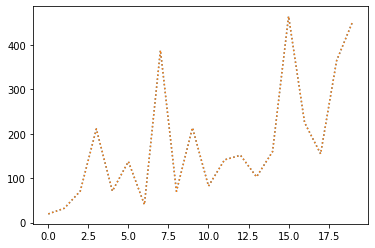

In [19]:
plot_simple_bco(test_hopper, test_pendulum_f)

In [26]:
(np.random.rand(ypoints[1:].shape[0])-0.7)*200

array([ -78.42204228,   42.18331636,  -93.21474983, -121.66048113,
        -66.53953675,   13.78156067,    0.68313318, -134.10851045,
       -128.67852491,  -52.18622644,   41.53719442,  -38.52551869,
        -51.09460727,   50.37090879,  -20.70895905,   29.94379646,
       -136.70889628,  -67.64006333,   40.06229804])

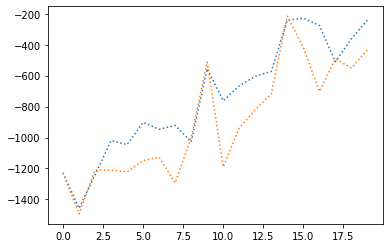

In [41]:
plot_simple_bco(test_pendulum, test_pendulum_f)

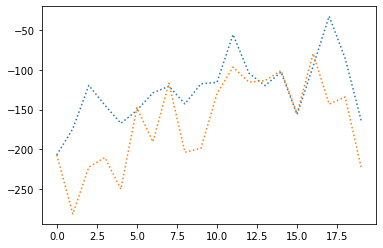

In [50]:
plot_simple_bco(test_walker, test_pendulum_f, s=30)

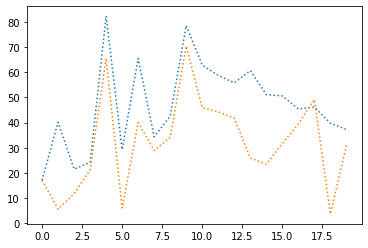

In [55]:
plot_simple_bco(test_half, test_pendulum_f, s=10)

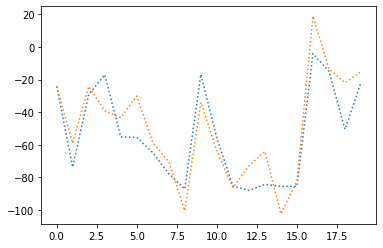

In [76]:
plot_simple_bco(test_bipedalwalker, test_pendulum_f, s=10, off=0.3)